# Имитационное и статистическое моделирование
# Лабораторная №3
## Акопян Павел, 2 группа

Состав лабораторной работы:
1. 

2.


### Предварительные манипуляции

импорт необходимых библиотек

In [1]:
import scipy.special as spc
import scipy.stats as sst
import pandas as pd
import numpy as np
import math
import copy
import os

from scipy.stats import chi2
from scipy.stats import chisquare

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import laplace
from scipy.stats import poisson
%matplotlib inline


np.set_printoptions(threshold='nan')

загрузка последовательности длины 500 000, полученной при помощи генератора A5/1

In [2]:
seq=np.genfromtxt("sshfloatsNew.csv")
print seq[0:10]
print len(seq)

[ 0.99997807  0.77915593  0.86126405  0.41514996  0.44683483  0.76780018
  0.85931374  0.77608803  0.84252442  0.94654109]
1000000


In [3]:
np.mean(seq)-0.5

0.00022656605928883522

In [4]:
np.var(seq)-1.0/12

0.00010894743353763447

# Базовое задание

# Реализация хи-квадрат теста

Вспомогательная функция, возвращает промежутки (bins), которые будут использоваться в хи-квадрат тесте. n_bins - число промежутков, которые будут между крайними значениями xmin и xmax. Также дополнительно выдаются промежутки (-Infinity;xmin) и (xmax;+Infinity).

In [5]:
def getBins(xmin,xmax,n_bins):
    r = np.linspace(xmin,xmax,num=n_bins+1,endpoint = True)
    r = r+10**(-10) # including rightmost
    r[0]=r[0]-2*10**(-10) # excluding xmin from (-Inf;xmin] bin
    return np.concatenate((np.array([float('-inf')]),r,np.array([float('inf')])))

Декоратор, принимающий на входе функцию распределения и возвращающий функцию, которая способна возвращать вероятности того, что СВ примет значения в промежутках bins.

In [6]:
# Calculates probabilities for each bin (a,b] within given cumulative distribution function 
def piCalcDecoratorNew(bins, *args):
    def real_piCalcDecorator(cdfFunc):
        def piCalc(*args):
            piA = np.zeros(len(bins)-1)
            if len(args)==1:
                args = args[0]
                piA[0] =cdfFunc(bins[1],args)  
                piA[-1] =1-cdfFunc(bins[-2],args)
                for i in range(1,len(bins)-2):
                    piA[i]=cdfFunc(bins[i+1],args)-cdfFunc(bins[i],args)
            else: #number of params >1
                piA[0] =cdfFunc(bins[1],*args)            
                piA[-1] =1-cdfFunc(bins[-2],*args)
                for i in range(1,len(bins)-2):
                    piA[i]=cdfFunc(bins[i+1],*args)-cdfFunc(bins[i],*args)
            return piA  
        return piCalc
    return real_piCalcDecorator

Функция расчитывающая хи-квадрат статистику по заданным наблюдаемым попаданиям в промежутки и ожидаемым теоретически. Аналог библиотечной функции chisquare(obs,exp)

In [7]:
# similar to scipy's chisquare()
def chi2statistic(obs = np.array([16, 18, 16, 14, 12, 12], dtype='float'), exp = np.array([16, 16, 16, 16, 16, 8],dtype='float')):
    temp = np.square(obs-exp,dtype='float')
    with np.errstate(divide='ignore',invalid='ignore'):
        temp = temp / exp
        temp[exp == 0] = 0
    return sum(temp)
    # like return chisquare(obs,exp)

Собственно хи-квадрат тест с параметрами: df - степени свободы, x - тестируемая последовательность, alpha - уровень значимости, cdfFunc и * args - функция распределения по которой проверяется последовательность и ее параметры.

In [8]:
def chi2test(df,x, alpha,cdfFunc,*args):
    N = len(x)
    xmin = min(x)
    xmax = max(x)
    bins = getBins(xmin,xmax,df-2)
    print "Bins for histogram are "
    print bins
    piCalc = piCalcDecoratorNew(bins,*args)(cdfFunc)
    piks = piCalc(*args)
    print "Expected probability to be in a bin"
    print sum(piks)
    print piks
    
    a = piks*float(N)
    b = np.histogram(x,bins)[0]
    print "Observed probabilities for bins"
    print sum(b/float(N))
    print b/float(N)
    print "========================================================="
    chi2Observed = chi2statistic(b,a)
    criticalValue = chi2.ppf(1-alpha,df)
    pval = chi2.sf(chi2statistic(b,a),df)
    print "Chi2 statistic is {0}".format(chi2Observed)
    print "Critical value is {0}".format(criticalValue)
    print "P-value is {0}".format(pval)
    return (chi2Observed,criticalValue,pval)

Проверка работы реализованного хи-квадрат теста на последовательность, генерируемыми библиотечными функциями.

Для нормального распределения

In [9]:
# Testing on scipy's norm
from scipy.stats import norm
alpha = 0.05
test_sequence = norm.rvs(loc=10.0, scale=2.0, size=100000, random_state=42)
print chi2test(10,test_sequence,alpha,norm.cdf,10.0,2.0)

Bins for histogram are 
[        -inf   1.06879227   3.3049643    5.54113633   7.77730836
  10.01348039  12.24965242  14.48582444  16.72199647  18.9581685
          inf]
Expected probability to be in a bin
1.0
[  3.99216127e-06   4.03701522e-04   1.24848993e-02   1.20317169e-01
   3.69479166e-01   3.66979729e-01   1.17880105e-01   1.20629311e-02
   3.84558409e-04   3.74819718e-06]
Observed probabilities for bins
1.0
[ 0.       0.00037  0.01255  0.12052  0.36815  0.36705  0.11908  0.01189
  0.00039  0.     ]
Chi2 statistic is 3.07999519078
Critical value is 18.3070380533
P-value is 0.979478275997
(3.0799951907815624, 18.307038053275143, 0.97947827599727133)


Для распределения Пуассона

In [10]:
# Testing on scipy's poisson
from scipy.stats import poisson
alpha = 0.05
test_sequence = poisson.rvs(mu=10, size=2000, random_state=42)

print chi2test(max(test_sequence)-10,test_sequence,alpha,poisson.cdf,10.0)

Bins for histogram are 
[        -inf   1.           3.22222222   5.44444444   7.66666667
   9.88888889  12.11111111  14.33333333  16.55555556  18.77777778  21.
          inf]
Expected probability to be in a bin
1.0
[  4.53999298e-05   1.02906507e-02   5.67499122e-02   1.53134684e-01
   2.37709068e-01   3.33626762e-01   1.24985051e-01   5.64168631e-02
   1.98551052e-02   6.48685409e-03   6.99650512e-04]
Observed probabilities for bins
1.0
[ 0.      0.0125  0.0565  0.16    0.2405  0.324   0.1265  0.049   0.023
  0.008   0.    ]
Chi2 statistic is 7.36666224007
Critical value is 19.6751375727
P-value is 0.768660842244
(7.3666622400733859, 19.675137572682491, 0.76866084224378395)


# Моделирование нормальной случайной величины

In [11]:
def Normal(loc =0.0,scale=1.0, N=20, seq=seq):
    result = np.zeros(N)
    for i in range(N-1):
        multiplicator = math.sqrt(-2.0*math.log(seq[i]))
        result[i] = math.cos(2.0*math.pi*seq[i+1])*multiplicator
        result[i+1] = math.sin(2.0*math.pi*seq[i+1]) * multiplicator
        i = i+2
    return result*scale+loc

Тестирование реализации нормального распределения

собственно моделирование (генерация)

In [18]:
loc = 10.0
scale=2.0
gaussian_numbers =Normal(loc,scale,N=len(seq),seq=seq)
gaussian_numbers =Normal(loc,scale,N=len(seq),seq=seq)

print gaussian_numbers[0:10]

[ 10.00241273  10.90924936   9.0586126    7.49462582  10.28333097
  10.92190758  10.17972128  10.78201782  11.10539123   9.7686858 ]


Проверка выборочного среднего и дисперсии

In [20]:
print "Mean observed is {0} ======= Mean expected is {1}".format(np.mean(gaussian_numbers),loc)
print "Varience is {0} ======= Variance expected is {1}".format(np.var(gaussian_numbers),scale**2)

Mean observed is 10.0018700411 ======= Mean expected is 10.0
Varience is 3.99980491953 ======= Variance expected is 4.0


Проверка тестом хи-квадрат

In [21]:
alpha = 0.037
df = 10
print chi2test(10,gaussian_numbers,alpha,norm.cdf,loc,scale)

Bins for histogram are 
[        -inf   0.21038463   2.67443751   5.13849038   7.60254326
  10.06659614  12.53064902  14.99470189  17.45875477  19.92280765
          inf]
Expected probability to be in a bin
1.0
[  4.92009544e-07   1.24253785e-04   7.40895781e-03   1.07783088e-01
   3.97964762e-01   3.83840934e-01   9.66212596e-02   6.16027603e-03
   9.56268146e-05   3.49927605e-07]
Observed probabilities for bins
1.0
[  0.00000000e+00   1.33000000e-04   7.40400000e-03   1.07477000e-01
   3.97748000e-01   3.84191000e-01   9.69000000e-02   6.05200000e-03
   9.50000000e-05   0.00000000e+00]
Chi2 statistic is 5.47882473215
Critical value is 19.2669608184
P-value is 0.856987519777
(5.4788247321502679, 19.266960818382699, 0.85698751977667698)


Гистограмма и функция плотности

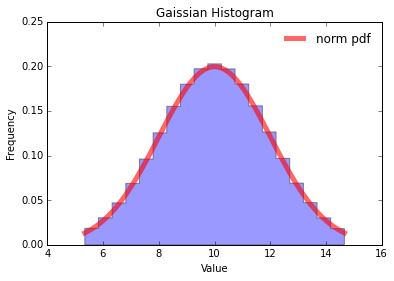

In [22]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01,loc,scale),norm.ppf(0.99, loc, scale), 100)
ax.plot(x, norm.pdf(x, loc,scale),'r-', lw=5, alpha=0.6, label='norm pdf')
n_hist = 20
ax.hist(gaussian_numbers,np.linspace(norm.ppf(0.01,scale=scale,loc=loc),norm.ppf(0.99, scale=scale,loc=loc), n_hist),normed=True, histtype='stepfilled', alpha=0.4)
ax.set_title("Gaissian Histogram")
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.legend(loc='best', frameon=False)

График выборочной функции распределения и истинной функции распределения

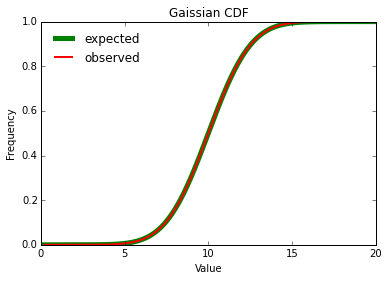

In [23]:
fig, ax = plt.subplots(1, 1)
x = np.sort(gaussian_numbers)
y = np.arange(1,len(x)+1,dtype='float')/len(x)
ax.plot(x, norm.cdf(x,scale=scale,loc=loc),'g', lw=5, label='expected' )

ax.plot(x, y,'r-', lw=2,  label='observed')


ax.set_title("Gaissian CDF")
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.legend(loc='best', frameon=False)

# Моделирование Лаплассовской случайной величины
### (двойное экспоненциальное распределение)

методом обратной функции

In [24]:
def LaplassInv(x,alpha=0.8,beta=1.0):
    if x<0.5:
        return beta + math.log(2.0*x)/alpha
    else:
        return beta - math.log(2-2*x)/alpha
def Laplass(alpha=2,beta=0.0,seq=seq):
    result = np.zeros(len(seq))
    for i in range(len(seq)):
        result[i] = LaplassInv(seq[i],alpha,beta)
    return result

Генерация

In [25]:
alpha = 3.0
beta=2.0
laplace_numbers =Laplass(alpha=alpha,beta=beta,seq=seq)
print laplace_numbers[0:10]

[ 5.34488773  2.27238373  2.4273452   1.93801057  1.96252697  2.25566993
  2.42269193  2.26778503  2.38511256  2.74523159]


Проверка по выборочному среднему и дисперсии

In [26]:
print "Mean observed is {0} ======= Mean expected is {1}".format(np.mean(laplace_numbers),beta)
print "Varience is {0} ======= Variance expected is {1}".format(np.var(laplace_numbers),2.0/alpha**2)

Mean observed is 2.00032861601 ======= Mean expected is 2.0
Varience is 0.222924252901 ======= Variance expected is 0.222222222222


Проверка тестом хи-квадрат

In [27]:
laplace_numbers[0:10]

array([ 5.34488773,  2.27238373,  2.4273452 ,  1.93801057,  1.96252697,
        2.25566993,  2.42269193,  2.26778503,  2.38511256,  2.74523159])

In [28]:
alphaT = 0.037
df = 10
print chi2test(10,laplace_numbers,alphaT,laplace.cdf,beta,1/alpha)

Bins for histogram are 
[       -inf -2.25711821 -1.18696638 -0.11681456  0.95333727  2.02348909
  3.09364092  4.16379275  5.23394457  6.3040964          inf]
Expected probability to be in a bin
1.0
[  1.42049976e-06   3.37942221e-05   8.37771442e-04   2.07686683e-02
   5.12379231e-01   4.47182339e-01   1.80385467e-02   7.27643152e-04
   2.93518411e-05   1.23376958e-06]
Observed probabilities for bins
1.0
[  0.00000000e+00   2.40000000e-05   8.45000000e-04   2.09930000e-02
   5.11536000e-01   4.47615000e-01   1.82250000e-02   7.32000000e-04
   3.00000000e-05   0.00000000e+00]
Chi2 statistic is 11.7522874786
Critical value is 19.2669608184
P-value is 0.301977061011
(11.752287478612546, 19.266960818382699, 0.30197706101143995)


Гистограмма и функция плотности

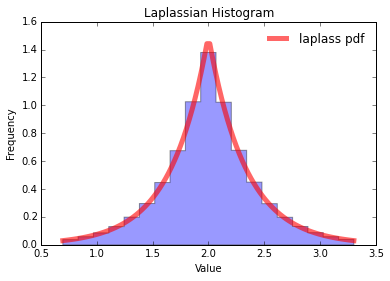

In [29]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(laplace.ppf(0.01,scale=1/alpha,loc=beta),laplace.ppf(0.99, scale=1/alpha,loc=beta), 100)
ax.plot(x, laplace.pdf(x, scale=1/alpha,loc=beta),'r-', lw=5, alpha=0.6, label='laplass pdf')
n_hist = 20
ax.hist(laplace_numbers,np.linspace(laplace.ppf(0.01,scale=1/alpha,loc=beta),laplace.ppf(0.99, scale=1/alpha,loc=beta), n_hist),normed=True, histtype='stepfilled', alpha=0.4)
ax.set_title("Laplassian Histogram")
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.legend(loc='best', frameon=False)

График выборочной функции распределения и истинной функции распределения

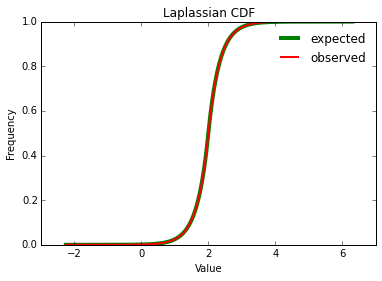

In [30]:
fig, ax = plt.subplots(1, 1)
x = np.sort(laplace_numbers)
y = np.arange(1,len(x)+1,dtype='float')/len(x)
ax.plot(x, laplace.cdf(x, scale=1/alpha,loc=beta),'g', lw=4, label='expected' )

ax.plot(x, y,'r-', lw=2,  label='observed')
ax.set_title("Laplassian CDF")
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.legend(loc='best', frameon=False)

# Моделирование Пуассоновской случайной величины

"наивная" реализация, требующая k БСВ для генерации одной Пуассоновской СВ

In [31]:
def PoissonNaive(lmbda = 2,k=250, count=30, seq=seq):
    p = float(lmbda)/k
    print "p must be <0.01. Now it is {0}".format(p)
    print "p*k must be <10. Now it is {0}".format(p*k)
    ksi = numpy.zeros(count)
    for i in range(count):
        for j in range(k):
            ksi[i]= ksi[i] + (1 if seq[count*i+j]<p else 0)
    return ksi   

Более эффективная реализация методом обратной функции для дискретных СВ

In [32]:
def PoissonCDF(lmbda = 2,k=5):
    #return poisson.cdf(k,lmbda)
    s = 0.0
    for i in range(int(math.floor(k))):
        s = s + math.pow(lmbda, i)/math.factorial(i)
    return s*math.pow(math.e,-lmbda)
def PoissonPMF(lmbda = 2,k=250):
    return math.pow(math.e,-lmbda)*math.pow(lmbda, k)/math.factorial(k)
    #return poisson.pmf(k,lmbda)

def Poisson(lmbda = 2,k=30, seq=seq):

    cdf = np.zeros(k+1)
    cdf[0] = PoissonPMF(lmbda = lmbda,k=0)
    for j in range(1,k+1):
        cdf[j]=cdf[j-1]+PoissonPMF(lmbda = lmbda,k=j)
    #print cdf
    ksi = np.digitize(seq, cdf-10**(-10))
    return ksi 

Генерация

In [33]:
lmbda = 2.0
k = 30
poisson_numbers =Poisson(lmbda=lmbda,k=k,seq=seq)
print poisson_numbers[0:10]

[10  3  4  2  2  3  4  3  3  4]


Проверка по выборочному среднему и дисперсии

In [34]:
print "Mean observed is {0} ======= Mean expected is {1}".format(np.mean(poisson_numbers),lmbda)
print "Varience is {0} ======= Variance expected is {1}".format(np.var(poisson_numbers),lmbda)

Mean observed is 2.000997 ======= Mean expected is 2.0
Varience is 2.00365800599 ======= Variance expected is 2.0


Проверка тестом хи-квадрат

In [35]:
alpha = 0.037
df = 10
print chi2test(10,poisson_numbers,alpha,poisson.cdf,lmbda)

Bins for histogram are 
[            -inf  -1.00000000e-10   1.50000000e+00   3.00000000e+00
   4.50000000e+00   6.00000000e+00   7.50000000e+00   9.00000000e+00
   1.05000000e+01   1.20000000e+01              inf]
Expected probability to be in a bin
1.0
[  0.00000000e+00   4.06005850e-01   4.51117611e-01   9.02235222e-02
   4.81192118e-02   3.43708656e-03   1.05022089e-03   3.81898506e-05
   8.10087741e-06   2.07346958e-07]
Observed probabilities for bins
1.0
[  0.00000000e+00   4.06140000e-01   4.50724000e-01   9.00540000e-02
   4.86240000e-02   3.40500000e-03   1.00500000e-03   4.00000000e-05
   8.00000000e-06   0.00000000e+00]
Chi2 statistic is 8.54277504612
Critical value is 19.2669608184
P-value is 0.575973806058
(8.5427750461221965, 19.266960818382699, 0.57597380605776272)


Гистограмма и функция вероятности

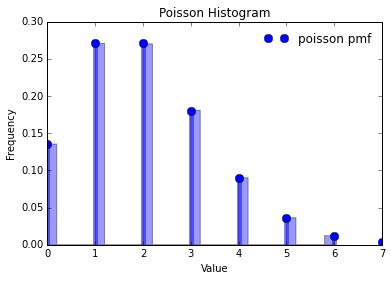

In [37]:
fig, ax = plt.subplots(1, 1)
x = np.arange(poisson.ppf(0.001, mu=lmbda), poisson.ppf(0.999, mu=lmbda))
ax.plot(x, poisson.pmf(x, mu=lmbda), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, poisson.pmf(x, mu=lmbda), colors='b', lw=5, alpha=0.5)

n_hist = k+1
weights = np.ones_like(poisson_numbers)/float(len(poisson_numbers))
ax.hist(poisson_numbers,np.linspace(poisson.ppf(0.01,mu=lmbda),poisson.ppf(0.99, mu=lmbda),n_hist),
        weights=weights, histtype='stepfilled', alpha=0.4)
ax.set_title("Poisson Histogram")
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.legend(loc='best', frameon=False)

График выборочной функции распределения и истинной функции распределения

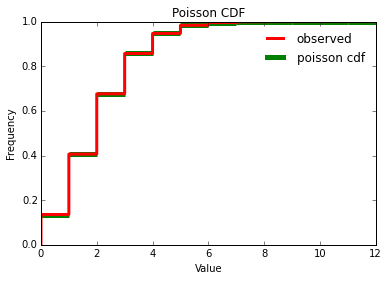

In [38]:
fig, ax = plt.subplots(1, 1)
x = np.sort(poisson_numbers)
y = np.arange(1,len(x)+1,dtype='float')/len(x)
#ax.plot(x, poisson.cdf(x, mu=lmbda),'g', lw=3, label='expected' )
uniq = np.unique(x)
uniqEnd = uniq+1
uniqEnd[-1] -= 0.95 
ax.hlines(poisson.cdf(uniq, mu=lmbda), uniq, uniqEnd, colors='g', lw=5,label='poisson cdf')
ax.plot(x, y,'r-', lw=3,  label='observed')
#ax.hist(poisson_numbers,uniq,normed=True,cumulative=True,histtype='stepfilled', alpha=0.4)
#ax.plot(x, poisson.pmf(x, mu=lmbda), 'bo', ms=8, label='poisson pmf')
#ax.vlines(x, 0, poisson.pmf(x, mu=lmbda), colors='b', lw=5, alpha=0.5)


ax.set_title("Poisson CDF")
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.legend(loc='best', frameon=False)

In [ ]:
'''fig, ax = plt.subplots(1, 1)
x = np.sort(poisson_numbers)
cumsum = np.cumsum(x, dtype=float)
cumsumNormed = cumsum/np.max(cumsum)
#ax.plot(x, poisson.cdf(x, mu=lmbda),'g', lw=3, label='expected' )
uniq = np.unique(x)
uniqEnd = uniq+1
uniqEnd[-1] -= 0.95 
ax.hlines(poisson.cdf(uniq, mu=lmbda), uniq, uniqEnd, colors='r', lw=3, alpha=0.5,label='poisson cdf')
#ax.plot(x, cumsumNormed,'r-', lw=3,  label='observed')
ax.hist(poisson_numbers,uniq,normed=True,cumulative=True,histtype='stepfilled', alpha=0.4)
#ax.plot(x, poisson.pmf(x, mu=lmbda), 'bo', ms=8, label='poisson pmf')
#ax.vlines(x, 0, poisson.pmf(x, mu=lmbda), colors='b', lw=5, alpha=0.5)


ax.set_title("Poisson CDF")
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.legend(loc='best', frameon=False)
'''

# Дополнительное задание 5
# Моделирование Гауссовского случайного вектора

In [74]:
ksi.shape

(4, 250000)

In [39]:
mu = [1,2,3,4]
sigma = [[13.1,4.2,9.0,2.7],[4.2,4.8,4.1,2.0],[9.0,4.1,10.8,3.6],[2.7,2.0,3.6,1.9]]
gn = Normal(loc=0,scale=1,N=len(seq)/4*4)


In [40]:
def GaussVector(mu,sigma,gn):
    eigen = np.linalg.eig(sigma)
    W = eigen[1] 
    lmda = np.sqrt(eigen[0])
    C = W.dot(np.diag(lmda))
    eta = np.reshape(gn,(4,-1))
    #eta = np.reshape(norm.rvs(loc=0,scale=1,size=len(seq)/4*4),(4,-1))
    muV=np.array([mu]).transpose()
    ksi = C.dot(eta)+muV
    print "Means are ",np.mean(ksi,axis=1)
    print "Variances are \n", np.cov(ksi)
    print "Max norm of cov matrix",np.max(np.cov(ksi)-sigma)
    return ksi

In [41]:
gn2 = norm.rvs(loc=0,scale=1,size=len(seq)/4*4)
ksi = GaussVector(mu,sigma,gn=gn2)

Means are  [ 0.99891741  2.00494151  3.00403033  4.00198394]
Variances are 
[[ 13.06818646   4.20130387   8.9790634    2.69473186]
 [  4.20130387   4.80646648   4.09787219   2.00011552]
 [  8.9790634    4.09787219  10.79481537   3.60258208]
 [  2.69473186   2.00011552   3.60258208   1.90395727]]
Max norm of cov matrix 0.00646648194363


# Дополнительное задание 4
Осуществить моделирование непрерывной случайной величины $ο$, функция распределения которой $F_{o}(x)$
имеет $k > 1$ точек разрыва; $F_{o}(x)$ выбрать самостоятельно, проверить точность
моделирования.

Выбранная функция распределения

In [42]:
def myCDF(x):
    if x<=0:
        return 0.0
    elif x>0 and x<2:
        return 3.0/2.0*x/10.0
    elif x>=2 and x<4:
        return 4/10.0
    elif x>=4 and x<6:
        return (x+1.0)/10.0
    elif x>=6 and x<8:
        return 8.0/10.0
    elif x>=8 and x<=10:
        return (0.5*x+5.0)/10.0
    else:
        return 1.0

График выбранной функции распределения

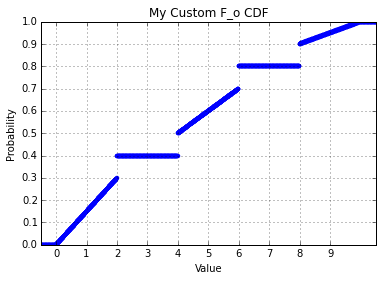

In [43]:
x = np.arange(-0.5,11,0.01)
y = map(myCDF,x)
plt.scatter(x,y, linewidth='0')
plt.ylabel('Probability')
plt.xlabel('Value')
plt.ylim((.0,1.0))
plt.xlim((-0.5,10.5))
plt.title("My Custom F_o CDF")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 10, 1))
plt.grid()
plt.show()

Моделирование СВ, имеющей выбранную функцию распределения

In [44]:
def myCdfModelling(seq=seq[0:20]):
    res = np.zeros(len(seq))
    for i in range(len(seq)):
        x = seq[i]
        if x<0.3:
            res[i]= x*2.0/0.3
        elif x>=0.3 and x<0.4:
            res[i]= 2.0
        elif x>=0.4 and x<0.5:
            res[i]=4.0
        elif x>=0.5 and x<0.7:
            res[i]= (x-0.5)/0.1+4.0
        elif x>=0.7 and x<0.8:
            res[i] = 6.0
        elif x>=0.8 and x<0.9:
            res[i] = 8.0
        elif x>=0.9 and x<=1.0:
            res[i] = (x-0.9)/0.1*2.0+8.0
        else:
            print "Error occured"
    return res

Подсчет ожидаемого матожидания и дисперсии

In [45]:
def ex2(a,b):
    return (a*a+a*b+b*b)/3.0
meanExpected = 1*0.3+2*0.1+4*0.1+5*0.2+6*0.1+8*0.1+9*0.1
meanSquareExpected = ex2(0,2)*0.3+4*0.1+16*0.1+ex2(4,6)*0.2+36*0.1+64*0.1+ex2(8,10)*0.1
varExpected = meanSquareExpected-meanExpected**2

Провека выборочного матожидания и дисперсии

In [46]:
mySeq = myCdfModelling(seq)
print mySeq[0:20]
print "Mean observed is {0} ======= Mean expected is {1}".format(np.mean(mySeq),4.2)
print "Varience is {0} ======= Variance expected is {1}".format(np.var(mySeq),varExpected)

[ 9.99956147  6.          8.          4.          4.          6.          8.
  6.          8.          8.93082178  2.          4.          5.63571269
  0.20848862  4.          1.26388821  0.42281657  6.          1.67697024
  8.        ]
Mean observed is 4.2030339936 ======= Mean expected is 4.2
Varience is 7.97456797176 ======= Variance expected is 7.96


Наблюдаемая выборочная функция распределения

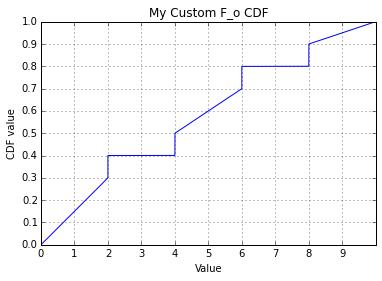

In [47]:
fig, ax = plt.subplots(1, 1)
x = np.sort(myCdfModelling(seq))
size = len(x)
r = np.arange(1,size+1,dtype='float')/size
y = np.zeros(size)
y[0] = 1.0/size
for i in range(1,size):
    if x[i]>=x[i-1]:
        y[i] = r[i]
    else:
        y[i]=y[i-1]
plt.plot(x,y)
plt.ylabel('CDF value')
plt.xlabel('Value')
plt.ylim((.0,1.0))
plt.xlim((0,10))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 10, 1))
plt.grid()
plt.title("My Custom F_o CDF")
plt.show()

Проверка $\chi^2$-тестом

In [48]:
alpha = 0.037
df = 10
print chi2test(10,mySeq,alpha,myCDF)

Bins for histogram are 
[            -inf   9.46989838e-06   1.25000520e+00   2.50000093e+00
   3.74999667e+00   4.99999240e+00   6.24998813e+00   7.49998386e+00
   8.74997959e+00   9.99997532e+00              inf]
Expected probability to be in a bin
1.0
[  1.42048476e-06   1.87499360e-01   2.12499220e-01   0.00000000e+00
   1.99999240e-01   2.00000760e-01   0.00000000e+00   1.37498980e-01
   6.24997866e-02   1.23376458e-06]
Observed probabilities for bins
1.0
[ 0.        0.187424  0.212467  0.        0.199693  0.199801  0.        0.13769
  0.062925  0.      ]
Chi2 statistic is 6.51614679175
Critical value is 19.2669608184
P-value is 0.770196890483
(6.5161467917457641, 19.266960818382699, 0.77019689048303752)


# Дополнительное задание 1

# Моделирование СВ с полиномиальным распределением

In [49]:
def Multinomial(p=[0.2,0.4,0.1,0.3],n=10,seq=seq[0:100]):
    dim = len(p)
    bins = np.zeros(dim+1)
    for i in range(0,dim):
        bins[i+1]=bins[i]+p[i]
    count = len(seq)/n
    res = np.zeros((count,dim))
    for i in range(count):
        block = seq[i*n:(i+1)*n]
        res[i,] = np.histogram(block,bins=bins)[0]
  
    return res

In [53]:
N = 50
P = np.array([0.2,0.4,0.1,0.3])
multi_numbers = Multinomial(p=P,n=N,seq=seq)

Проверка по выборочному матожиданию и дисперсии

In [57]:
# нахождение ковариационной матрицы для полиномиального распределения
def covMulti(p=np.array([0.2,0.4,0.1,0.3]),n=10):
    central = N*p*(1-p)
    other = -N*np.outer(p,p)
    other.flat[::len(other)+1] = central
    return other

In [58]:
N = 50
P = np.array([0.2,0.4,0.1,0.3])
multi_numbers = Multinomial(p=P,n=N,seq=seq)
print multi_numbers[0:5,:]
print "Mean observed is \n{0}\nMean expected is \n{1}".format(np.mean(multi_numbers,axis=0),P*N)
print "Varience is \n{0}\n Variance expected is\n {1}".format(np.cov(multi_numbers,rowvar=False),covMulti(P,N))

[[  9.  15.   5.  21.]
 [  6.  26.   3.  15.]
 [ 10.  17.   8.  15.]
 [ 11.  21.   7.  11.]
 [ 11.  16.   5.  18.]]
Mean observed is 
[  9.9946   19.98465   4.98935  15.0314 ]
Mean expected is 
[ 10.  20.   5.  15.]
Varience is 
[[  7.89776573  -3.82677423  -0.93870445  -3.13228705]
 [ -3.82677423  11.81910533  -2.09506823  -5.89726287]
 [ -0.93870445  -2.09506823   4.52616289  -1.49239021]
 [ -3.13228705  -5.89726287  -1.49239021  10.52194014]]
 Variance expected is
 [[  8.   -4.   -1.   -3. ]
 [ -4.   12.   -2.   -6. ]
 [ -1.   -2.    4.5  -1.5]
 [ -3.   -6.   -1.5  10.5]]


# Дополнительное задание 2
# Реализовать тест Колмогорова

In [60]:
from scipy.stats import kstwobign
def myKSinv(alpha):
    return math.sqrt(-math.log((1.0-alpha)/2.0)/2.0)
print myKSinv(1-0.037)
kstwobign.ppf(1-0.037)

1.41244195401


1.4124408332975502

In [66]:
def KolmogorovTest(seq,cdf,alpha=0.037, verbose=True,*args):
    x = np.sort(seq)
    size = len(x)
    r = np.arange(1,size+1,dtype='float')/size
    y = np.zeros(size)
    y[0] = 1.0/size
    for i in range(1,size):
        if x[i]>=x[i-1]:
            y[i] = r[i]
        else:
            y[i]=y[i-1]
    expected = map(lambda a: cdf(a,*args),x)
    KSstatistic = math.sqrt(len(x))*np.max(y-expected)
    if verbose:
        print "Kolmogorov-Smirnov Statistic is ",np.max(y-expected)
        print "sqrt(n)*D is ", KSstatistic
        print "Critical value is ",myKSinv(1-alpha)
        #print "Critical value is ",kstwobign.ppf(1-alpha)
        print "P-value is ",1-kstwobign.cdf(KSstatistic)
    if KSstatistic<myKSinv(1-alpha):
        return 1
    else:
        return 0

In [67]:
KolmogorovTest(norm.rvs(size =100000,random_state=42),norm.cdf,0.037,True,0,1)

Kolmogorov-Smirnov Statistic is  0.000933544210053
sqrt(n)*D is  0.295212600023
Critical value is  1.41244195401
P-value is  0.999993959255


1

In [68]:
sst.kstest(norm.rvs(size =100000,random_state=42),'norm',alternative="greater")

KstestResult(statistic=0.00093354421005298338, pvalue=0.8395216890950703)

In [69]:
KolmogorovTest(gaussian_numbers2[0:500000] ,cdf=norm.cdf, alpha=0.037)

Kolmogorov-Smirnov Statistic is  0.000755548788854
sqrt(n)*D is  0.534253672116
Critical value is  1.41244195401
P-value is  0.937742431017


1

# Дополнительное задание 3

Осуществить моделирование двух серий, каждую из которых составляют $U = 30 000$ независимых реализаций случайной величины. Законы распределения вероятностей для каждой из серий выбрать самостоятельно (законы должны быть различными): $R_{1}$ – распределение вероятностей для первой серии, $R_{2}$ – для второй. С помощью критерия согласия для каждой реализации осуществить проверку гипотез $H_0^{(i)} =\{$реализация согласуется с распределением вероятностей $R_i \}$, против альтернатив $H_1^{(i)} = \overline{H_0^{(i)}}, i = 1,2$. Для каждой из двух смоделированных серий длины $U$ вычислить величины: $\zeta_{(i)} = \displaystyle\sum_{u=1}^U I_u\{H_1^{(i)}\}$, $i = 1, 2$,
где $I_u\{H_1^{(i)}\}= 1$, если для $u$-ой реализации принимается решение в пользу
альтернативы $H_1^{(i)}$, $I_u\{H_1^{(i)}\} = 0$ в противном случае.

In [70]:
seq1 = Normal(10,2,N=len(seq),seq=seq)
alpha = 3.0
beta=2.0
seq2 = 

In [71]:
U = 30000
count = len(seq)/U

In [73]:
s1 = 0.0
s2 = 0.0
for i in range(U):
    block1 = seq1[i*count:i*count+count]
    block2 = seq2[i*count:i*count+count]
    s1 +=KolmogorovTest(block1,norm.cdf,0.037,False,10,2)
    s2 +=KolmogorovTest(block2,laplace.cdf,0.037,False,1/alpha,beta)
print s1
print s2
print s1/U
print s2/U

29514.0
30000.0
0.9838
1.0


In [75]:
1-0.037

0.963

In [ ]:
block

In [77]:
s1 = 0.0
s2 = 0.0
for i in range(U):
    block1 = seq1[i*count:i*count+count]
    block2 = seq2[i*count:i*count+count]
    s1 +=KolmogorovTest(block1,laplace.cdf,0.037,False,1/alpha+1,beta+1)
    s2 +=KolmogorovTest(block2,norm.cdf,0.037,False,10,2)
print s1
print s2
print "============="
print s1/U
print s2/U

30000.0
0.0
1.0
0.0


# Нормальное vs Вейбулл

In [83]:
from scipy.stats import weibull_min
c = 1.78661669304
seq1 = norm.rvs(loc=1,scale=3,size=3000000)
seq2 = weibull_min.rvs(c, size=3000000)
U = 30000
count = len(seq1)/U

In [86]:
s1 = 0.0
s2 = 0.0
for i in range(U):
    if i%1000==0:
        print "Processed ",i
    block1 = seq1[i*count:i*count+count]
    block2 = seq2[i*count:i*count+count]
    s1 +=KolmogorovTest(block2,norm.cdf,0.037,False,1,3)
    s2 +=KolmogorovTest(block1,weibull_min.cdf,0.037,False,c)
print "===================="
print s1
print s2
print "============="
print s1/U
print s2/U

Processed  0
Processed  1000
Processed  2000
Processed  3000
Processed  4000
Processed  5000
Processed  6000
Processed  7000
Processed  8000
Processed  9000
Processed  10000
Processed  11000
Processed  12000
Processed  13000
Processed  14000
Processed  15000
Processed  16000
Processed  17000
Processed  18000
Processed  19000
Processed  20000
Processed  21000
Processed  22000
Processed  23000
Processed  24000
Processed  25000
Processed  26000
Processed  27000
Processed  28000
Processed  29000
0.0
0.0
0.0
0.0


In [85]:
1-0.037

0.963

Тест на всём библиотечном